## Stim-coding vs. Accuracy-coding for within-subject design

This script is used for debugging.

The question I hope to answer is: What is the best way to model a task of within-subject design and the two responses represent different stimuli. And I can't continue because when I tried to fit simulated data with HDDM (accuracy-coding) and HDDMregressor, the parameter recovery was completely off.

First prepare the packages.

I used a virtue env in conda, with similar setting to my [docker image](https://hub.docker.com/r/hcp4715/hddm/).

In [1]:
#check which python is in use.
import sys
print('Notebook is running:', sys.executable)

# further check your python version
from platform import python_version

print('The current Python version is', python_version())

# If you are sure that conda is installed, also check the package that install
#!conda list  # list the conda

import hddm, IPython, kabuki, pymc
import numpy as np
import pandas as pd
import seaborn as sns
print('The current HDDM version is', hddm.__version__) # 0.8.0
print('The current Kabuki version is', kabuki.__version__) # 0.6.3
print('The current PyMC version is', pymc.__version__) # 2.3.8

# Warning:`IPython.parallel` package has been deprecated since IPython 4.0. 
print('The current IPython version is', IPython.__version__) 

print('The current Numpy version is', np.__version__) 

print('The current Pandas version is', pd.__version__)

print('The current seaborn version is', sns.__version__)

Notebook is running: /home/hcp4715/miniconda3/envs/hddm/bin/python
The current Python version is 3.7.7
The current HDDM version is 0.8.0
The current Kabuki version is 0.6.3
The current PyMC version is 2.3.8
The current IPython version is 7.13.0
The current Numpy version is 1.18.5
The current Pandas version is 1.0.4
The current seaborn version is 0.11.1


/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


Load the packages for analysis.

In [2]:
%matplotlib inline

# Preparation
import os, time, csv
from datetime import date
import random

import kabuki, hddm
from patsy import dmatrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')  # Ignore all the warnings

### Example: Within-subject design where the response direction are meaningful

In this case, we actually have 2 * 3 design, the first factor is concening the stimulus type, and linked to different response. In this case, there is a strong interaction between the two factors, and for the condition B, there is no sig differences between the three levels, either in RT or ACC, but in condition A, there is sig diff. 

Let's assume the ground true of the model parameter is as below:

**Parameter for condation A:**

level1a = {'v':1.5, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

level2a = {'v':1.6, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}

level3a = {'v':2.0, 'a':2, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}

**Parameter for condation B:**

level1b = {'v':1.5, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

level2b = {'v':1.5, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

level3b = {'v':1.5, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}


**How can we model the simulated data?**

There are multiple ways:

#### Accuracy-coding + HDDM
That is, we treat the data as accuracy-coding and use the base function. The pseudo code is like:

m1 = hddm:HDDM(depends_on = {'v': [Stim, levels], 'z':[Stim, levels]}, ...)


#### Accuracy-coding + regressor
That is, we treat the data as accuracy-coding with within-subject design. The pseudo code is like:

m4 = hddm:HDDMRegressor{ 'v' ~ Stim * levels, 'z' ~ stim * levels, link:lamda invlogit_without_multiplying_sim}


Note, I also tried Stim-coding with both between-subject approach (HDDMStimcoding) and regression approach. But in this notebook, I will focus on the regressor model first.

### Steps for stimulation:

Step 1: simulate the data

Step 2: check the data itself

Step 3: fit the data with six models mentioned above

Step 4: Compare the models' DIC and PPC

Step 5: Conclusion and recommendataion

### Step 1: Generate simulation data

Generate the data


In [3]:
# set number of subjects and number of trials per level for the simulated experiment
n_subjects = 30
trials_per_level = 60

# Next, set up parameters of the DDM for three levels and the first stimulus. 
level1a = {'v':1.5, 'a':1.3, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level2a = {'v':1.6, 'a':1.3, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level3a = {'v':2.0, 'a':1.3, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}

# Next, set up parameters for the second stimulus, where `v` is the different as for the first stimulus. 
# and `z(stimulus_b) = 1 - z(stimulus_a)`. 
level1b = {'v':1.4, 'a':1.3, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level2b = {'v':1.4, 'a':1.3, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level3b = {'v':1.4, 'a':1.3, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

Generate data, using the same parameters but assume the it's all within-subject.

In [4]:
#### Generate data
random.seed(123)
np.random.seed(123)

# I used this way to generate data so that data cross different conditions are correlated within subject.
mydata, params = hddm.generate.gen_rand_data({'level1': level1a,
                                                'level2': level2a,
                                                'level3': level3a,
                                                'level4': level1b,
                                                'level5': level2b,
                                                'level6': level3b},
                                              size=trials_per_level,
                                              subjs=n_subjects)

mydata['stimulus'] = np.where(((mydata['condition'] == 'level1') |
                              (mydata['condition'] == 'level2') |
                              (mydata['condition'] == 'level3')) , 1, 2)

mydata.loc[(mydata['condition'] == 'level4'),'condition']= 'level1'
mydata.loc[(mydata['condition'] == 'level5'),'condition']= 'level2'
mydata.loc[(mydata['condition'] == 'level6'),'condition']= 'level3'


#### Get  parameters from the simulation for later use.

cols = ['condition', 'subj_idx', 'params', 'value']
row = []
df_params = pd.DataFrame([], columns = cols)

for level in params.keys(): 
    data_row = params[level]
    for subj, data in enumerate(data_row):
        for key, value in data.items():
            row = [[level, subj, key, value]]
            data = pd.DataFrame(row, columns=cols)
            df_params = df_params.append(data, ignore_index=True)

df_params = df_params.pivot_table(index = ['condition','subj_idx'], columns =['params'], 
                                  values =['value']).reset_index() 

col_ind = ['condition','subj_idx', 'a_pop', 'st_pop','sv_pop', 'sz_pop', 't_pop', 'v_pop', 'z_pop']
df_params.columns = col_ind

df_params['stimulus'] = np.where(((df_params['condition'] == 'level1') |
                              (df_params['condition'] == 'level2') |
                              (df_params['condition'] == 'level3')) , 1, 2)

df_params.loc[(df_params['condition'] == 'level4'),'condition']= 'level1'
df_params.loc[(df_params['condition'] == 'level5'),'condition']= 'level2'
df_params.loc[(df_params['condition'] == 'level6'),'condition']= 'level3'

df_params['StimType'] = np.where((df_params['stimulus'] == 1) , 'left', 'right')

df_params.head()

,condition,subj_idx,a_pop,st_pop,sv_pop,sz_pop,t_pop,v_pop,z_pop,stimulus,StimType
0,level1,0,1.399735,0.149139,0.165144,0.126594,0.328298,1.391437,0.157332,1,left
1,level1,1,1.220791,0.133319,0.015975,0.058869,0.367458,1.436110,0.233952,1,left
2,level1,2,1.315234,0.034590,0.037492,0.243941,0.360005,1.652525,0.171825,1,left
3,level1,3,1.262625,0.095630,0.099299,0.102319,0.265328,1.422619,0.290780,1,left
4,level1,4,1.263466,0.009696,0.031619,0.074624,0.518431,1.475317,0.473331,1,left


### Step 2: Check the data itself

#### Plot the average RT and ACC

As people would do in traditional ways.

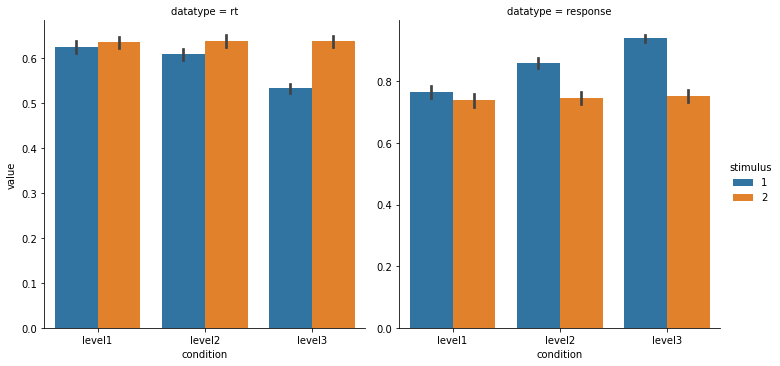

In [5]:
## plot the RT and Accuracy
# wide-to-long format
df_plot = pd.melt(mydata, 
                  id_vars=['subj_idx', 'condition','stimulus'], 
                  value_vars=['rt', 'response'],
                  var_name='datatype')

g = sns.catplot(data=df_plot, x='condition', y='value', hue='stimulus', col='datatype', kind='bar',
               sharex=False, sharey=False)

In [6]:
# combine the parameters to the data
df_acc = mydata.copy() # cannot use df_acc = mydata, otherwise, mydata will be also changed as df_acc change
df_acc['StimType'] = np.where(df_acc['stimulus'] == 1.0, 'left', 'right')

df_acc = pd.merge(df_acc, df_params)

In [7]:
df_acc.head()

,rt,response,subj_idx,condition,stimulus,StimType,a_pop,st_pop,sv_pop,sz_pop,t_pop,v_pop,z_pop
0,0.437767,0.0,0,level1,1,left,1.399735,0.149139,0.165144,0.126594,0.328298,1.391437,0.157332
1,0.383435,0.0,0,level1,1,left,1.399735,0.149139,0.165144,0.126594,0.328298,1.391437,0.157332
2,0.281557,0.0,0,level1,1,left,1.399735,0.149139,0.165144,0.126594,0.328298,1.391437,0.157332
3,0.362459,0.0,0,level1,1,left,1.399735,0.149139,0.165144,0.126594,0.328298,1.391437,0.157332
4,0.576269,1.0,0,level1,1,left,1.399735,0.149139,0.165144,0.126594,0.328298,1.391437,0.157332


#### Plot the correlation between condtions.

Here we analyze the data as an experiment and plot it's summary data. More importantly, we will check the correaltion between different condition across subjects.

What we found?

RT and ACC are correlated with each other across conditions, looks like data from within-subject design.

In [8]:
def plot_sum_cor(df, var = 'rt'):
    '''
    df: simulated dataframe
    var: the variable of which the summary data will be plotted, i.e., rt or response
    '''
    df_sum = df.groupby(['subj_idx', 'condition', 'StimType'])[var].mean().reset_index()

    # long to wide for pair plots
    df_sum_wide = df_sum.pivot_table(index=['subj_idx'], 
                                     columns=['condition','StimType'],
                                          #aggfunc='size', 
                                     values = var,     
                                     fill_value=0) 

    df_sum_wide.columns = df_sum_wide.columns.map('_'.join)
    df_sum_wide = df_sum_wide.reset_index() 

    # plot pairs with regression lines
    sns.pairplot(df_sum_wide.loc[:, df_sum_wide.columns != 'subj_idx'], kind="reg")
    
    print('Here is the correlation matrix of ', var)
    print(df_sum_wide.loc[:, df_sum_wide.columns != 'subj_idx'].corr())

Here is the correlation matrix of  rt
              level1_left  level1_right  level2_left  level2_right  \
level1_left      1.000000      0.936725     0.892304      0.925483   
level1_right     0.936725      1.000000     0.936693      0.915062   
level2_left      0.892304      0.936693     1.000000      0.858780   
level2_right     0.925483      0.915062     0.858780      1.000000   
level3_left      0.806778      0.853386     0.934531      0.803339   
level3_right     0.937927      0.900586     0.912781      0.880051   

              level3_left  level3_right  
level1_left      0.806778      0.937927  
level1_right     0.853386      0.900586  
level2_left      0.934531      0.912781  
level2_right     0.803339      0.880051  
level3_left      1.000000      0.871170  
level3_right     0.871170      1.000000  


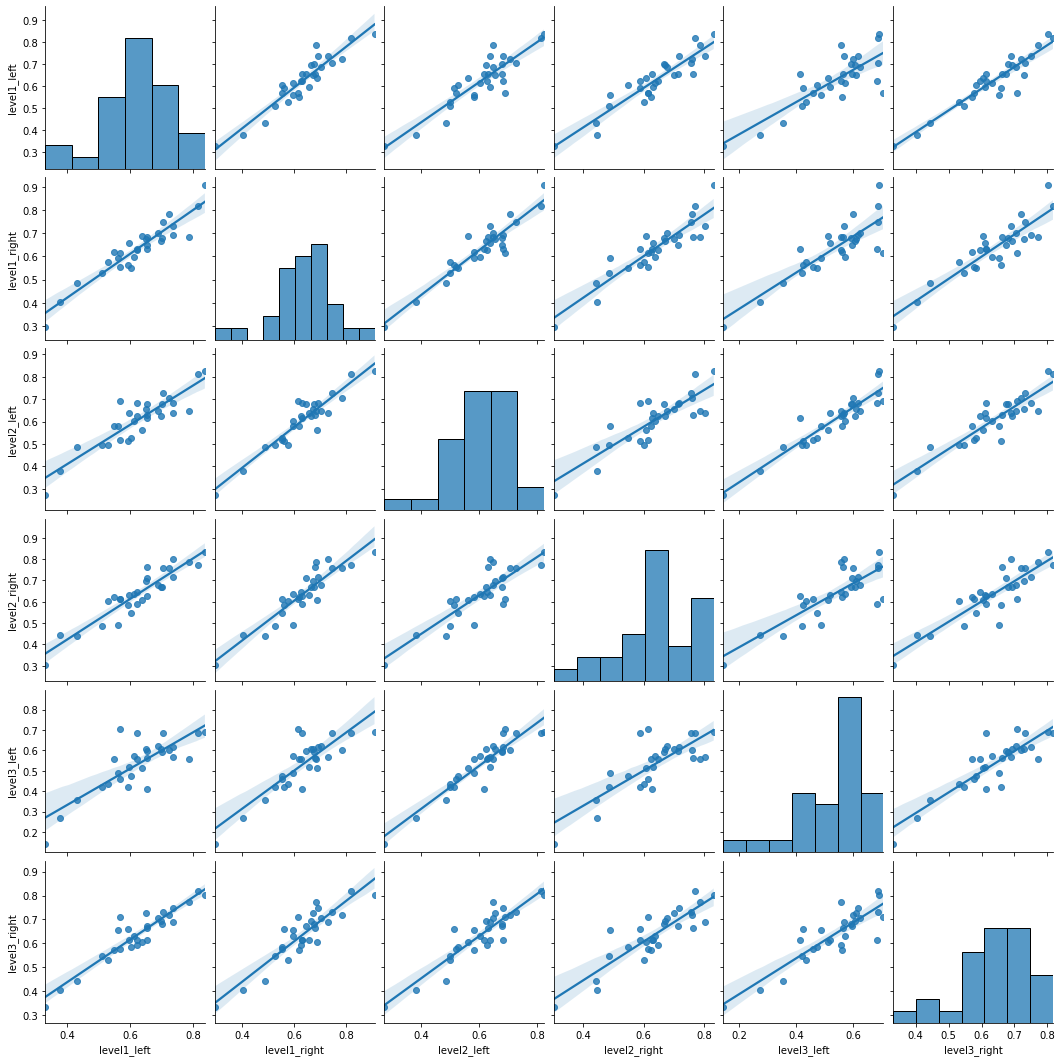

In [9]:
plot_sum_cor(df_acc, 'rt')   # check the correlation between diff conditions (RT)

Here is the correlation matrix of  response
              level1_left  level1_right  level2_left  level2_right  \
level1_left      1.000000      0.873483     0.751402      0.884106   
level1_right     0.873483      1.000000     0.774076      0.891757   
level2_left      0.751402      0.774076     1.000000      0.698936   
level2_right     0.884106      0.891757     0.698936      1.000000   
level3_left      0.778589      0.762370     0.821937      0.728074   
level3_right     0.890392      0.875885     0.821204      0.875447   

              level3_left  level3_right  
level1_left      0.778589      0.890392  
level1_right     0.762370      0.875885  
level2_left      0.821937      0.821204  
level2_right     0.728074      0.875447  
level3_left      1.000000      0.713577  
level3_right     0.713577      1.000000  


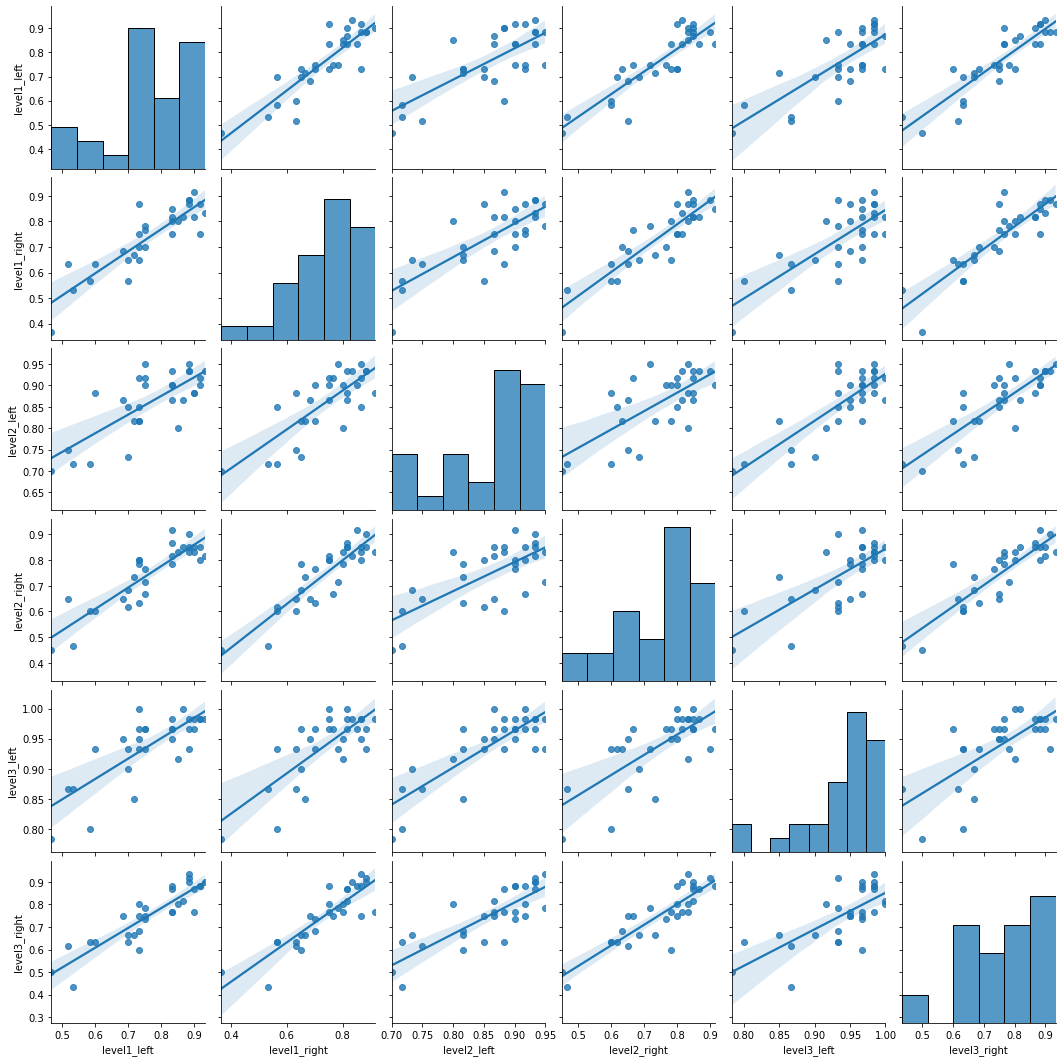

In [10]:
plot_sum_cor(df_acc, 'response')  # check the correlation between diff conditions (response)

#### M1: Accuracy coding + HDDM

The first model, use the simple between-subject design model and accuracy-coding. This looks like the most unlikely.

m1 = hddm:HDDM(depends_on = {'v': [Stim, levels], 'z':[Stim, levels]},...)

Please uncomment the cell below to run the m1 if you haven't.

In [11]:
# m1 = hddm.HDDM(df_acc, depends_on={'v': ['condition', 'StimType'], 'z': ['condition', 'StimType']}, 
#                include=['v', 'z', 't'],p_outlier=.05)

# m1.find_starting_values()
# m1.sample(4000,burn=2000, dbname='stim_sim_m1.db', db='pickle')
# # 2001 of 2000 complete in 1797.8 sec

# # save the model
# m1.save('stim_sim_m1')

# # m1.print_stats()

If you have run the m1 and saved the model, then you can load it by running the cell below:

In [12]:
# load the model data if it was previously saved
m1 = hddm.load('stim_sim_m1')

#### Check parameter recovery

Check the correlation between recovered parameters and the ground truth.

In [13]:
def gen_params_comp(m, df_params):
    '''
    A function to merge the parameters recovered from model fitting with the ground truth of simulation.
    for later plotting and correlation analysis
    '''
    
    m_stats = m.gen_stats()
    m_stats['params'] = m_stats.index
    m_stats.head()

    m_stats_subj = m_stats[m_stats['params'].str.contains("z_subj|v_subj")]
    
    ## split the strings to create a dataframe more friendly for plot
    m_stats_subj[['param','subj']] = m_stats_subj['params'].str.split("_",expand=True) 
    m_stats_subj[['subj','conds','subj_idx']] = m_stats_subj['subj'].str.split("\(|\)",expand=True) 

    # https://stackoverflow.com/questions/46124469/shape-mismatch-indexing-arrays-could-not-be-broadcast-together-with-shapes
    m_stats_subj[['subj_idx']] = m_stats_subj['subj_idx'].str.split(".",expand=True)[1][:,np.newaxis] 
    m_stats_subj[['StimType', 'condition']] = m_stats_subj['conds'].str.split(".",expand=True).loc[:,0:1]
    m_stats_subj = m_stats_subj.drop(['subj', 'conds'], axis=1).copy()

    m_stats_subj_wide = m_stats_subj.pivot_table(index=['subj_idx', 'condition', 'StimType'], 
                                     columns=['param'],
                                     aggfunc='first', 
                                     values = 'mean',     
                                     fill_value=0) 
    #m1_stats_subj_wide.columns = m1_stats_subj_wide.columns.map('_'.join)
    m_stats_subj_wide.reset_index(inplace=True)  

    # reset the index
    m_stats_subj_wide.index = df_params.index

    # change the data type of 'subj_idx'
    m_stats_subj_wide['subj_idx'] = m_stats_subj_wide['subj_idx'].astype(int)
    
    # Merge the recovered parameter with the ground truth.
    df_params_ppc = pd.merge(df_params, m_stats_subj_wide)
    
    return df_params_ppc  

In [14]:
tmp = gen_params_comp(m1, df_params)  # get the data

# correlation between variables.
tmp.groupby(['StimType', 'condition'])[['v','v_pop','z', 'z_pop']].corr()

v     v_pop         z     z_pop
StimType condition                                              
left     level1    v      1.000000  0.351163  0.417848  0.570136
                   v_pop  0.351163  1.000000  0.156168  0.089086
                   z      0.417848  0.156168  1.000000  0.919048
                   z_pop  0.570136  0.089086  0.919048  1.000000
         level2    v      1.000000  0.392596  0.335998  0.446045
                   v_pop  0.392596  1.000000  0.166295  0.089086
                   z      0.335998  0.166295  1.000000  0.897039
                   z_pop  0.446045  0.089086  0.897039  1.000000
         level3    v      1.000000  0.419315  0.478150  0.516260
                   v_pop  0.419315  1.000000  0.101416  0.089086
                   z      0.478150  0.101416  1.000000  0.905896
                   z_pop  0.516260  0.089086  0.905896  1.000000
right    level1    v      1.000000  0.541838  0.646962  0.711895
                   v_pop  0.541838  1.000000  0.167063  0.089086
                   z      0.646962  0.167063  1.000000  0.919828
                   z_pop  0.711895  0.089086  0.919828  1.000000
         level2    v      1.000000  0.436490  0.255070  0.500871
                   v_pop  0.436490  1.000000  0.040523  0.089086
                   z      0.255070  0.040523  1.000000  0.923596
                   z_pop  0.500871  0.089086  0.923596  1.000000
         level3    v      1.000000  0.495268  0.631779  0.729714
                   v_pop  0.495268  1.000000  0.052713  0.089086
                   z      0.631779  0.052713  1.000000  0.940642
                   z_pop  0.729714  0.089086  0.940642  1.000000

Plot the correlation between groud truth (`z_pop`, `v_pop`) and the recovered parameters (`z`, `v`)

[None, None]

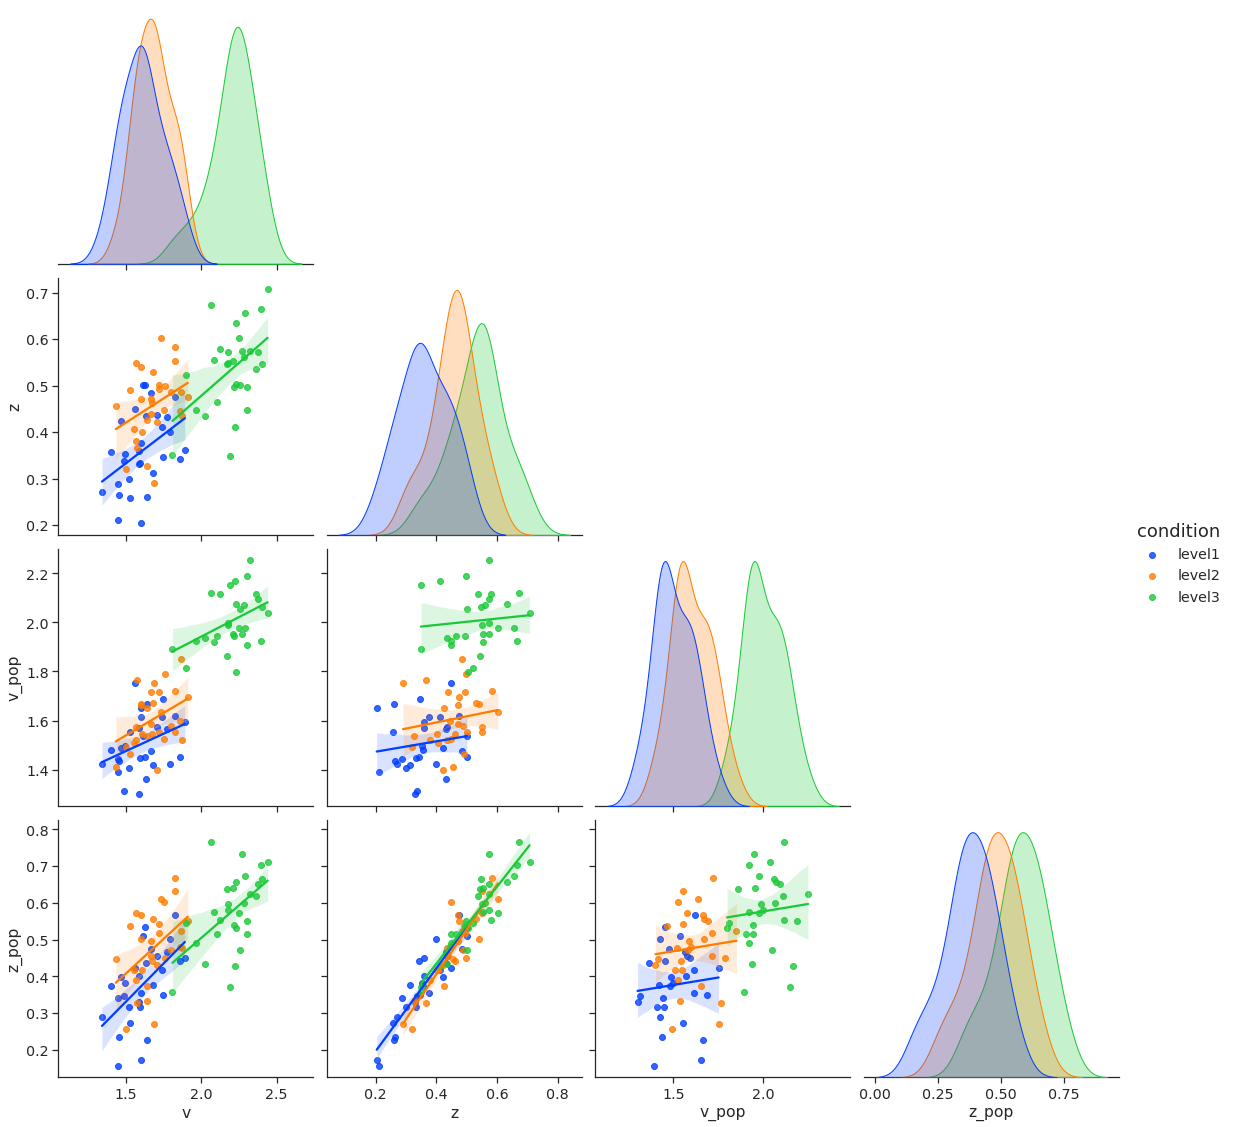

In [15]:
# plot the correlation between recovered parameter and the ground truth
# for parameters related to stimulus 1
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(tmp.loc[tmp['StimType'] == 'left', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

[None, None]

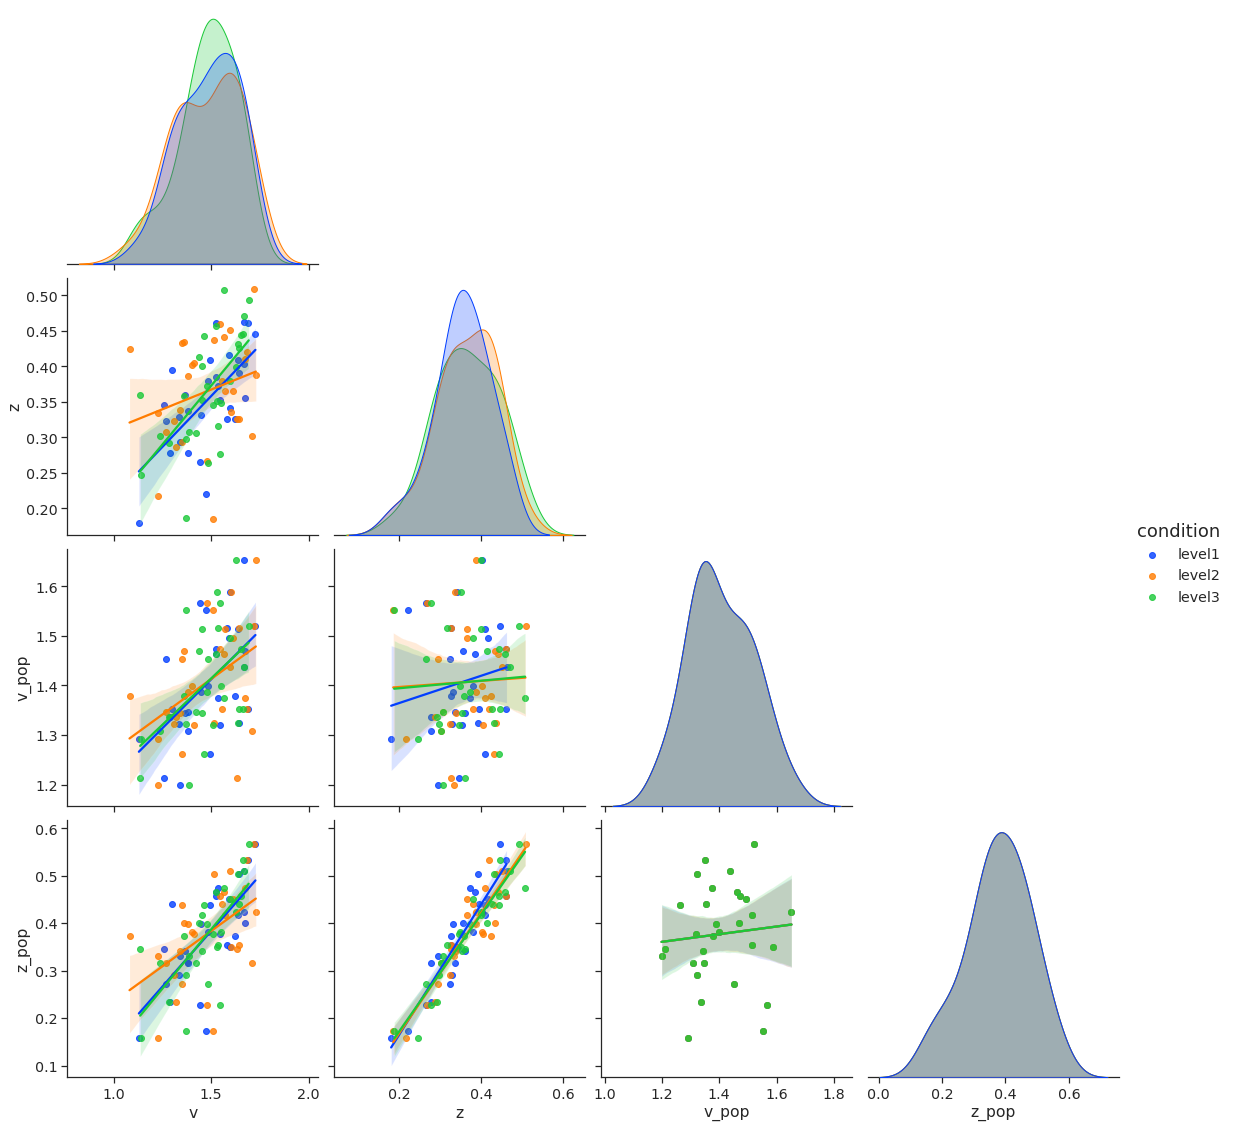

In [16]:
# plot the correlation between recovered parameter and the ground truth
# for parameters related to stimulus 2
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(tmp.loc[tmp['StimType'] == 'right', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

#### M4: Accuracy-coding + regressor
In this model, we treat the data as accuracy-coding with within-subject design. The pseudo code is like:

m4 = hddm:HDDMRegressor{ 'v' ~ Stim * levels, 'z' ~ stim * levels, 'link_func': link_func}

Note that we are using the default setting of patsy, which is reduced-rank coding. That is, one level is chosen as the “reference”, and its mean behaviour is represented by the intercept. Each column of the resulting matrix represents the difference between the mean of one level and this reference level.

For full-rank coding, classic “dummy” coding is used, and each column of the resulting matrix represents the mean of the corresponding level.

https://patsy.readthedocs.io/en/latest/API-reference.html#handling-categorical-data

We can have look at the regressors added to the regression formula: 

In [17]:
## check the regressor in the design

# full rank coding
dm = dmatrix("0 + C(condition, Treatment) * C(StimType, Treatment)", data=df_acc)

In [18]:
dm

DesignMatrix with shape (10800, 6)
  Columns:
    ['C(condition, Treatment)[level1]',
     'C(condition, Treatment)[level2]',
     'C(condition, Treatment)[level3]',
     'C(StimType, Treatment)[T.right]',
     'C(condition, Treatment)[T.level2]:C(StimType, Treatment)[T.right]',
     'C(condition, Treatment)[T.level3]:C(StimType, Treatment)[T.right]']
  Terms:
    'C(condition, Treatment)' (columns 0:3)
    'C(StimType, Treatment)' (column 3)
    'C(condition, Treatment):C(StimType, Treatment)' (columns 4:6)
  (to view full data, use np.asarray(this_obj))

In [19]:
print('unique rows of the design matrix')
pd.DataFrame(dm).drop_duplicates() # get the unique combination of the matrix

unique rows of the design matrix


,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0
60,0.0,1.0,0.0,0.0,0.0,0.0
120,0.0,0.0,1.0,0.0,0.0,0.0
180,1.0,0.0,0.0,1.0,0.0,0.0
240,0.0,1.0,0.0,1.0,1.0,0.0
300,0.0,0.0,1.0,1.0,0.0,1.0


In [20]:
# reduced rank coding
dm2 = dmatrix("1 + C(condition, Treatment) * C(StimType, Treatment)", data=df_acc)

print('Show the column name of the design matrix')
dm2

Show the column name of the design matrix


DesignMatrix with shape (10800, 6)
  Columns:
    ['Intercept',
     'C(condition, Treatment)[T.level2]',
     'C(condition, Treatment)[T.level3]',
     'C(StimType, Treatment)[T.right]',
     'C(condition, Treatment)[T.level2]:C(StimType, Treatment)[T.right]',
     'C(condition, Treatment)[T.level3]:C(StimType, Treatment)[T.right]']
  Terms:
    'Intercept' (column 0)
    'C(condition, Treatment)' (columns 1:3)
    'C(StimType, Treatment)' (column 3)
    'C(condition, Treatment):C(StimType, Treatment)' (columns 4:6)
  (to view full data, use np.asarray(this_obj))

Please note the different between the "full rank" and "reduced rank" design matrices

In [21]:
print('unique rows of the design matrix')
pd.DataFrame(dm2).drop_duplicates()

unique rows of the design matrix


,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0
60,1.0,1.0,0.0,0.0,0.0,0.0
120,1.0,0.0,1.0,0.0,0.0,0.0
180,1.0,0.0,0.0,1.0,0.0,0.0
240,1.0,1.0,0.0,1.0,1.0,0.0
300,1.0,0.0,1.0,1.0,0.0,1.0


In [22]:
# z_reg4 = {'model': "z ~ 1 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 
#          'link_func': lambda x:1/(1+np.exp(-x))}

# v_reg4 = {'model': "v ~ 1 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 
#          'link_func': lambda x:x}

# reg_descr4 = [z_reg4, v_reg4]

# # Note here the 'group_only_regresors' is set to 'false'
# m4 = hddm.HDDMRegressor(df_acc, reg_descr4, group_only_regressors=False, keep_regressor_trace=True, include='z')

# m4.find_starting_values()

# m4.sample(5000, burn=2500, dbname='stim_sim_m4_1.db', db='pickle') # 54392.1 sec (53285.6 sec for 15000 samples)

# # save the model
# m4.save('stim_sim_m4_1')

# m4.print_stats()

In [23]:
m4 = hddm.load('stim_sim_m4_1')

Check the column names of the traces

In [24]:
m_traces = m4.get_traces()
slct_col_names = m_traces.columns[m_traces.columns.str.contains("z_")]
m_traces = m_traces[slct_col_names].copy()

slct_col_names

Index(['z_Intercept_trans', 'z_Intercept_std', 'z_Intercept_subj_trans.0',
       'z_Intercept_subj_trans.1', 'z_Intercept_subj_trans.2',
       'z_Intercept_subj_trans.3', 'z_Intercept_subj_trans.4',
       'z_Intercept_subj_trans.5', 'z_Intercept_subj_trans.6',
       'z_Intercept_subj_trans.7',
       ...
       'z_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.20',
       'z_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.21',
       'z_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.22',
       'z_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.23',
       'z_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.24',
       'z_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.25',
       'z_C(condition, Treatment('level1'))[T.level3]:C(StimType, 

Now, let's check the traces of one participant `sub 0`

In [25]:
# select the trace names of subj.0
trace_name = m_traces.columns[m_traces.columns.str.contains("subj.0|subj_trans.0")]

trace_name

Index(['z_Intercept_subj_trans.0',
       'z_C(condition, Treatment('level1'))[T.level2]_subj.0',
       'z_C(condition, Treatment('level1'))[T.level3]_subj.0',
       'z_C(StimType, Treatment('left'))[T.right]_subj.0',
       'z_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]_subj.0',
       'z_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.0'],
      dtype='object')

In [26]:
subj_id = 0
subj_name = 'subj.' + str(subj_id)

# get the trace name of each effect
l_l1_name = 'z' + "_Intercept_subj_trans." + str(subj_id)  # intercept
l_l2_eff_name = 'z' + "_C(condition, Treatment('level1'))[T.level2]_" + subj_name
l_l3_eff_name = 'z' + "_C(condition, Treatment('level1'))[T.level3]_" + subj_name 
r_l1_eff_name = 'z' + "_C(StimType, Treatment('left'))[T.right]_" + subj_name
r_l2_int_name = 'z' + "_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]_" + subj_name
r_l3_int_name = 'z' + "_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_" + subj_name

tmp_l_l1 = m_traces[l_l1_name].copy()
#1/(1+np.exp(-x))
# exp(z_trans)/(1+exp(z_trans)) 
#tmp_l_l1 = 1/(1+np.exp(-tmp_l_l1))
tmp_l_l1 = np.exp(tmp_l_l1)/(1+np.exp(tmp_l_l1))

tmp_l_l2 = m_traces[l_l2_eff_name].copy()
tmp_l_l2 = np.exp(tmp_l_l2)/(1+np.exp(tmp_l_l2))

tmp_l_l3 = tmp_l_l1 + m_traces[l_l3_eff_name].copy()
tmp_l_l3 = np.exp(tmp_l_l3)/(1+np.exp(tmp_l_l3))

tmp_r_l1 = tmp_l_l1 + m_traces[r_l1_eff_name].copy()
tmp_r_l1 = np.exp(tmp_r_l1)/(1+np.exp(tmp_r_l1))

tmp_r_l2 = tmp_r_l1 + m_traces[r_l2_int_name].copy()
tmp_r_l2 = np.exp(tmp_r_l2)/(1+np.exp(tmp_r_l2))

tmp_r_l3 = tmp_r_l1 + m_traces[r_l3_int_name].copy()
tmp_r_l3 = np.exp(tmp_r_l3)/(1+np.exp(tmp_r_l3))

dd = pd.concat([tmp_l_l1, tmp_l_l2, tmp_l_l3, tmp_r_l1, tmp_r_l2, tmp_r_l3], axis=1)
dd.columns = ['left_level1_value', 'left_level2_value', 'left_level3_value', 
              'right_level1_value', 'right_level2_value', 'right_level3_value']
dd
# df_subj_traces = pd.DataFrame(columns = ['params','subj_idx', 'left_level1_value', 'left_level2_value',
#                                          'left_level3_value', 'right_level1_value', 'right_level2_value', 
#                                          'right_level3_value'])

,left_level1_value,left_level2_value,left_level3_value,right_level1_value,right_level2_value,right_level3_value
0,0.025594,0.404790,0.499989,0.279741,0.623911,0.570688
1,0.022949,0.424258,0.460821,0.290593,0.626534,0.583705
2,0.023541,0.377526,0.414327,0.273385,0.621786,0.561949
3,0.024152,0.421801,0.413452,0.287057,0.625133,0.568408
4,0.023699,0.402416,0.431936,0.289220,0.622070,0.597684
...,...,...,...,...,...,...
2495,0.028510,0.428449,0.471985,0.281017,0.626829,0.645980
2496,0.028446,0.419578,0.401019,0.296374,0.605918,0.604222
2497,0.022966,0.398352,0.472279,0.279419,0.621683,0.595641
2498,0.025257,0.421832,0.422046,0.281212,0.619115,0.623946


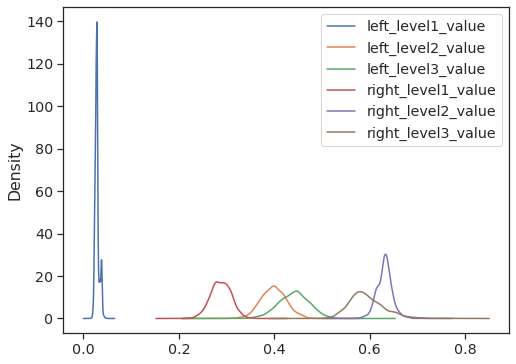

In [27]:
dd.plot.density(figsize=(8,6))

In [28]:
n_subjects = 30
def gen_params_comp_reg(m, df_params):
    '''
    merge the group-level parameters from model fitting with the ground truth of simulation.
    for later plotting and correlation analysis
    This function is for reduced rank model.
    
    Note, need to converte z_trans back to z
    Link: https://groups.google.com/g/hddm-users/c/k0SfUbQ-Tnw
    z = exp(z_trans)/(1+exp(z_trans)) 
    
    '''
    m_traces = m.get_traces()
    
    # create an empty dataframe to store the parameters.
    df_subj_traces = pd.DataFrame(columns = ['params','subj_idx', 'left_level1_value', 'left_level2_value',
                                             'left_level3_value', 'right_level1_value', 'right_level2_value', 
                                             'right_level3_value'])
    for subj_id in range(n_subjects):
        for param in ['v', 'z']:
            if param == 'v':
                # create strings for extracting the traces of 'v' for each condition
                subj_name = 'subj.' + str(subj_id)
                
                # Name for intercept, which is left_level1's parameter
                l_l1_name = 'v' + "_Intercept_" + subj_name 
                # Name for the difference between left_level2 and intercept
                l_l2_eff_name = 'v' + "_C(condition, Treatment('level1'))[T.level2]_" + subj_name 
                # Name for the diff between left_level3 and intercept
                l_l3_eff_name = 'v' + "_C(condition, Treatment('level1'))[T.level3]_" + subj_name 
                # name for the diff between right_level1 and intercept
                r_l1_eff_name = 'v' + "_C(StimType, Treatment('left'))[T.right]_" + subj_name
                # Name for the diff between right_level2 and right_level1 (interaction of right_level2)
                r_l2_int_name = 'v' + "_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]_" + subj_name
                # Name for the diff between right_level3 and right_level1 (interaction of right_level3)
                r_l3_int_name = 'v' + "_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_" + subj_name
                
                # get the data (MCMC traces of all these conditions)
                tmp_l_l1 = m_traces[l_l1_name].copy()
                tmp_l_l2 = tmp_l_l1 + m_traces[l_l2_eff_name].copy()
                tmp_l_l3 = tmp_l_l1 + m_traces[l_l3_eff_name].copy()
                tmp_r_l1 = tmp_l_l1 + m_traces[r_l1_eff_name].copy()
                tmp_r_l2 = tmp_r_l1 + m_traces[r_l2_int_name].copy()
                tmp_r_l3 = tmp_r_l1 + m_traces[r_l3_int_name].copy()
            else:
                # create strings for extracting the traces of 'z' for each condition
                subj_name = 'subj.' + str(subj_id)
                l_l1_name = 'z' + "_Intercept_subj_trans." + str(subj_id)
                l_l2_eff_name = 'z' + "_C(condition, Treatment('level1'))[T.level2]_" + subj_name
                l_l3_eff_name = 'z' + "_C(condition, Treatment('level1'))[T.level3]_" + subj_name
                r_l1_eff_name = 'z' + "_C(StimType, Treatment('left'))[T.right]_" + subj_name
                r_l2_int_name = 'z' + "_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]_" + subj_name
                r_l3_int_name = 'z' + "_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_" + subj_name

                tmp_l_l1 = m_traces[l_l1_name].copy()
                
                # transfer z_trans to z, using exp(z_trans)/(1+exp(z_trans)), which is equal to 1/(1+np.exp(-x))
                tmp_l_l1 = np.exp(tmp_l_l1)/(1+np.exp(tmp_l_l1))

                tmp_l_l2 = m_traces[l_l2_eff_name].copy()
                tmp_l_l2 = np.exp(tmp_l_l2)/(1+np.exp(tmp_l_l2))

                tmp_l_l3 = tmp_l_l1 + m_traces[l_l3_eff_name].copy()
                tmp_l_l3 = np.exp(tmp_l_l3)/(1+np.exp(tmp_l_l3))

                tmp_r_l1 = tmp_l_l1 + m_traces[r_l1_eff_name].copy()
                tmp_r_l1 = np.exp(tmp_r_l1)/(1+np.exp(tmp_r_l1))

                tmp_r_l2 = tmp_r_l1 + m_traces[r_l2_int_name].copy()
                tmp_r_l2 = np.exp(tmp_r_l2)/(1+np.exp(tmp_r_l2))

                tmp_r_l3 = tmp_r_l1 + m_traces[r_l3_int_name].copy()
                tmp_r_l3 = np.exp(tmp_r_l3)/(1+np.exp(tmp_r_l3))

            # put all these six conditions' mean data together   
            dat= [[param, subj_id, np.mean(tmp_l_l1), np.mean(tmp_l_l2), np.mean(tmp_l_l3), 
                   np.mean(tmp_r_l1), np.mean(tmp_r_l2), np.mean(tmp_r_l3)]]
            
            # create a dataframe from those data
            dd = pd.DataFrame(dat, columns = ['params','subj_idx', 'left_level1_value', 'left_level2_value', 'left_level3_value', 'right_level1_value', 'right_level2_value', 'right_level3_value'])
            
            # append the above as a row for the final dataframe
            df_subj_traces = df_subj_traces.append(dd, ignore_index=True)
                                             

    # melt the dataframe, i.e., wide to long format
    df_subj_traces = pd.melt(df_subj_traces, id_vars=['subj_idx', 'params'], 
                             value_vars=['left_level1_value', 'left_level2_value', 'left_level3_value',
                                         'right_level1_value', 'right_level2_value', 'right_level3_value'])

    df_subj_traces[['StimType','condition','v_name']] = df_subj_traces['variable'].str.split("_",expand=True)
    
    # Long to wide so the v and z are from different columns 
    df_subj_traces = df_subj_traces.pivot_table(index=['subj_idx', 'condition','StimType'], columns='params', values='value')
    df_subj_traces.reset_index(inplace=True) 
    
    # change the data type of 'subj_idx'
    df_subj_traces['subj_idx'] = df_subj_traces['subj_idx'].astype(int)
    df_params_ppc = pd.merge(df_params, df_subj_traces)
    
    return df_params_ppc  

In [29]:
df_params_ppc = gen_params_comp_reg(m4, df_params)
df_params_ppc.head(10)

,condition,subj_idx,a_pop,st_pop,sv_pop,sz_pop,t_pop,v_pop,z_pop,stimulus,StimType,v,z
0,level1,0,1.399735,0.149139,0.165144,0.126594,0.328298,1.391437,0.157332,1,left,0.144310,0.028578
1,level1,1,1.220791,0.133319,0.015975,0.058869,0.367458,1.436110,0.233952,1,left,0.532551,0.028638
2,level1,2,1.315234,0.034590,0.037492,0.243941,0.360005,1.652525,0.171825,1,left,0.596434,0.028563
3,level1,3,1.262625,0.095630,0.099299,0.102319,0.265328,1.422619,0.290780,1,left,0.545168,0.028731
4,level1,4,1.263466,0.009696,0.031619,0.074624,0.518431,1.475317,0.473331,1,left,1.288089,0.028854
5,level1,5,1.294093,0.055814,0.123352,0.058723,0.110663,1.552762,0.272671,1,left,0.779291,0.028699
6,level1,6,1.307747,0.000287,0.104315,0.112984,0.407852,1.752137,0.423434,1,left,1.450329,0.028826
7,level1,7,1.419132,0.093412,0.071068,0.098720,0.362393,1.614573,0.417595,1,left,1.344943,0.028799
8,level1,8,1.201195,0.013551,0.014275,0.114220,0.344928,1.688700,0.350757,1,left,1.253064,0.028743
9,level1,9,1.241328,0.120765,0.014519,0.088042,0.334857,1.563807,0.466106,1,left,1.250995,0.028828


Plot the correlation between groud truth (`z_pop`, `v_pop`) and the recovered parameters (`z`, `v`)

[None, None]

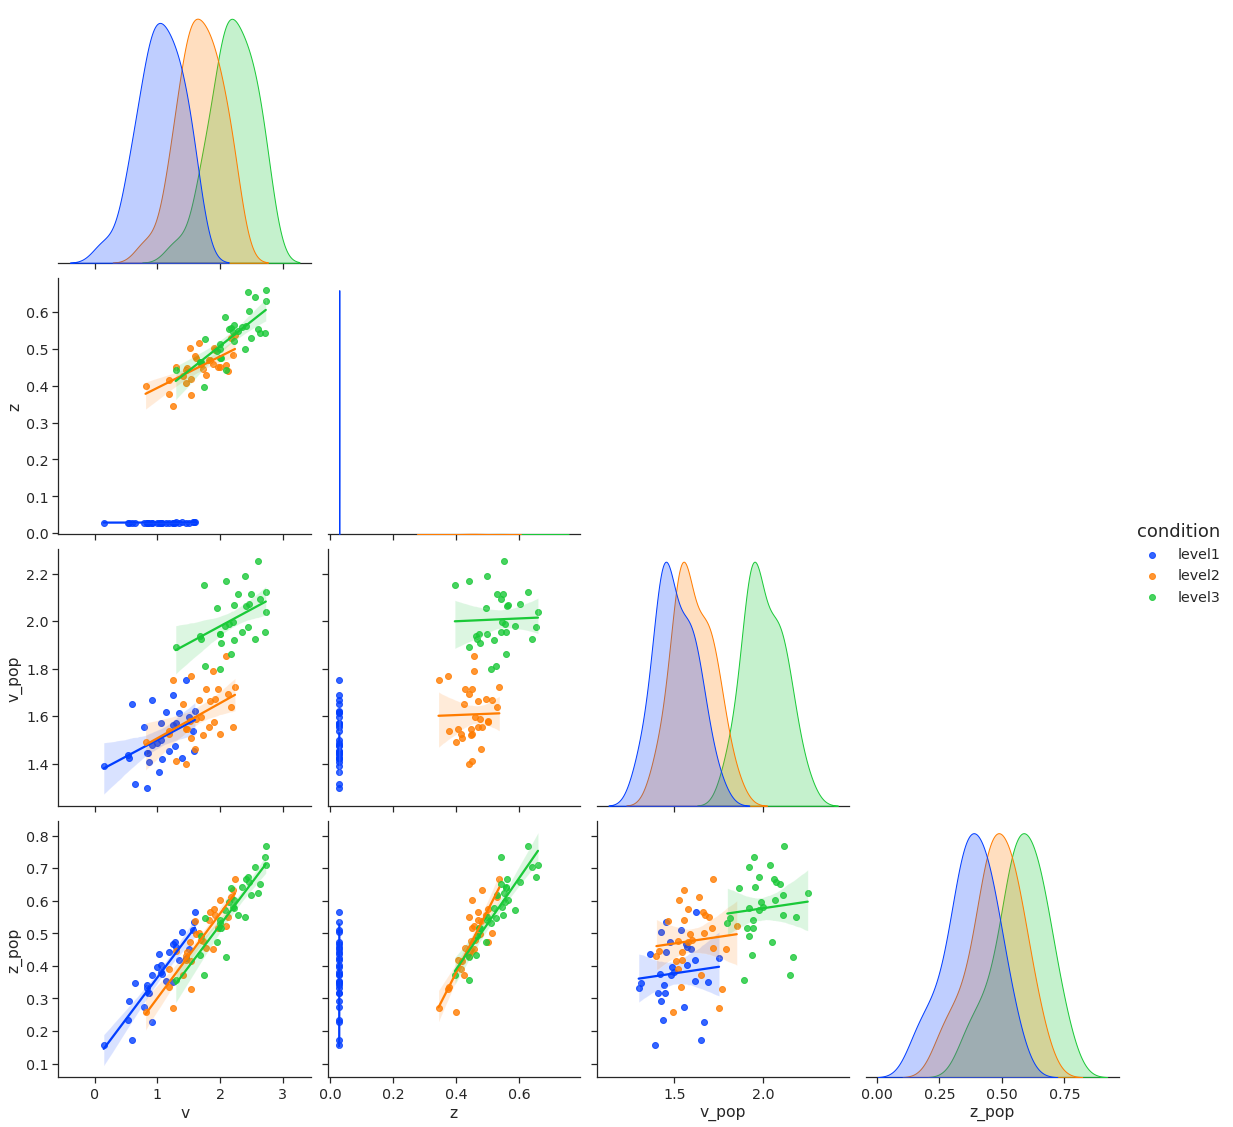

In [30]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(df_params_ppc.loc[df_params_ppc['StimType'] == 'left', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright",
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

[None, None]

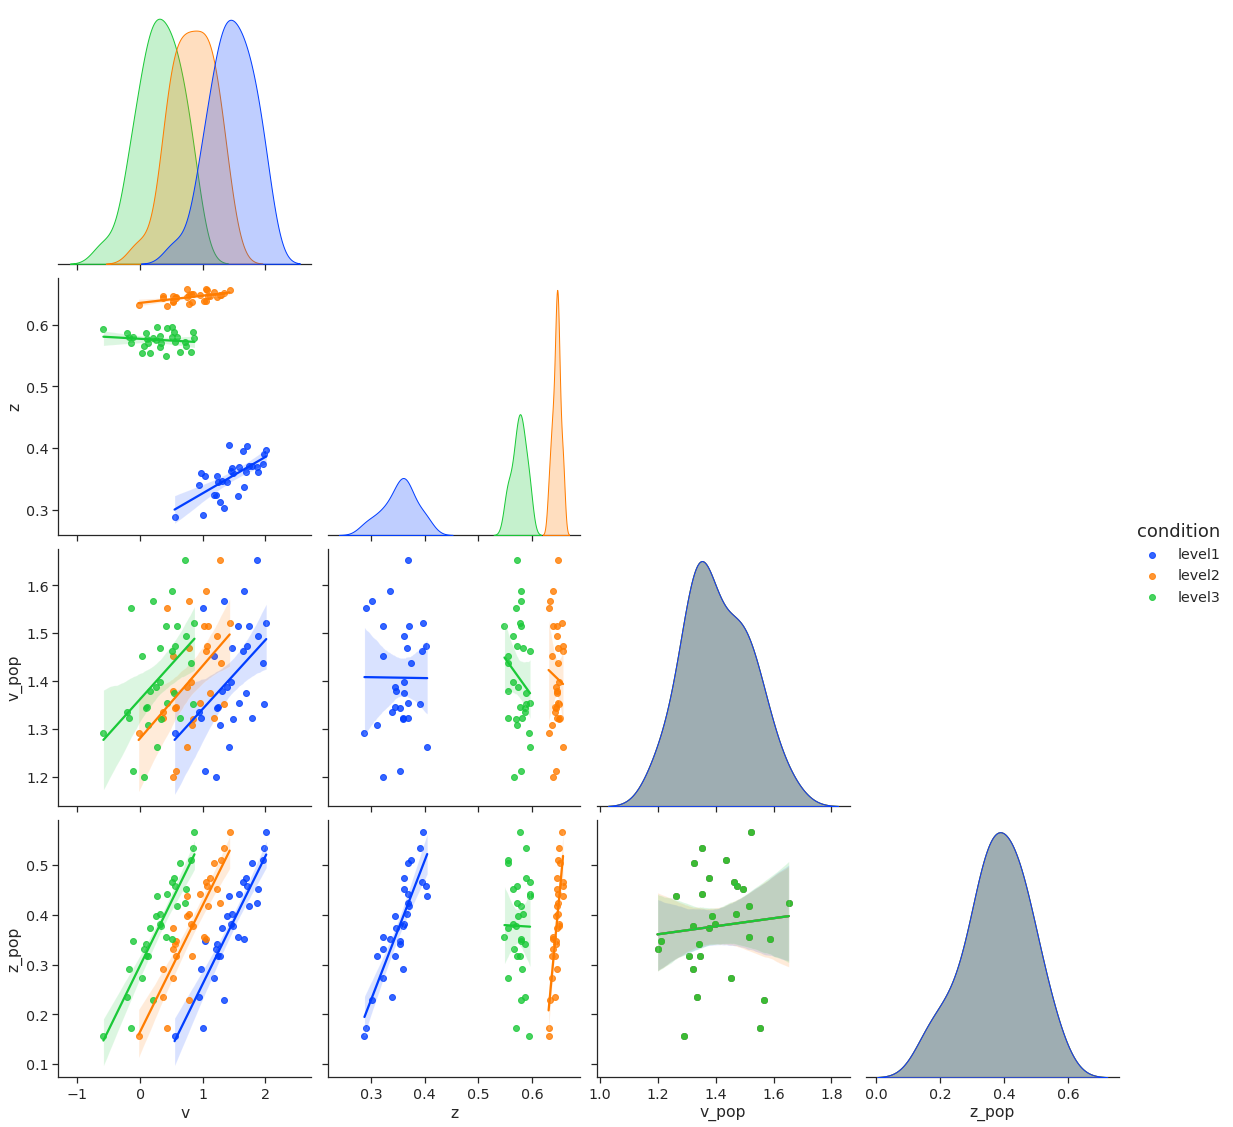

In [31]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(df_params_ppc.loc[df_params_ppc['StimType'] == 'right', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)